In [4]:
from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lars, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import cohen_kappa_score
import os

%matplotlib inline
sns.set_context('talk',font_scale=1)

In [5]:
### SETUP TRAINING DATA (from clicic visits) ###

# get all data and remove useless rows
Xtrain_t = pd.read_pickle('//FS2.smpp.local/RTO/CIS-PD Study/MJFF Curation/ClinicSmartWatchFeatures_HP.pkl')
Xtrain_b = pd.read_pickle('//FS2.smpp.local/RTO/CIS-PD Study/MJFF Curation/ClinicSmartWatchFeatures_HP+LP.pkl')
Xtrain_t = Xtrain_t[Xtrain_t.Subject!=1020]
Xtrain_b = Xtrain_b[Xtrain_b.Subject!=1020]
Xtrain_t = Xtrain_t[~Xtrain_t['Tremor'].isnull()]
Xtrain_b = Xtrain_b[~Xtrain_b['Bradykinesia'].isnull()]
Xtrain_t = Xtrain_t.reset_index(drop = True)
Xtrain_b = Xtrain_b.reset_index(drop = True)

# get tremor training target
indp_t = Xtrain_t['Tremor']
indp_t = indp_t.values
ytrain_tremor = indp_t.astype(int)

# get bradykinesia training target
indp_b = Xtrain_b['Bradykinesia']
indp_b = indp_b.values
ytrain_bradykinesia = indp_b.astype(int)

# get the training data set
Xtrain_t = Xtrain_t.iloc[:,5:].values
Xtrain_b = Xtrain_b.iloc[:, 5:].values

# train a classifier to predict the tremor score
clf_tremor = RandomForestRegressor(n_estimators=100, max_features = 0.5, random_state=2)
clf_tremor.fit(Xtrain_t, ytrain_tremor)

# train a classifier to predict the bradykinesia score
clf_bradykinesia = RandomForestRegressor(n_estimators=100, max_features = 0.5, random_state=2)
clf_bradykinesia.fit(Xtrain_b, ytrain_bradykinesia)

### organize data
task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')
Data = pd.DataFrame()
for f in task_feature_files:
    if(Data.empty):
        Data = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f)
    else:
        d = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f)
        Data = Data.append(d, ignore_index = True)
Data = Data[Data.Subject!=1020]
for index, row in Data.iterrows():
    if (row['Visit'] == '4 Weeks'):
        Data.loc[index, 'Visit'] = '1 Month'
np.sort(Data.Subject.unique())
Data = Data.reset_index(drop=True)
Dataorig = Data.copy()


tasks = Dataorig['Task'].unique()
features_for_each_subj = {}
final_features = pd.DataFrame()
for subject in Dataorig['Subject'].unique():
    
    # setup data
    summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
    Data = Dataorig.copy()
    Data = Data[Data['Subject'] == subject]
    Data = Data.reset_index(drop=True)

    # get MDS and Baseline MDS scores
    for index, row in Data.iterrows(): 
        try:
            Data.loc[index, 'MDS score'] = int(summary_info.loc[(summary_info.VisitNm == row['Visit']) & (summary_info["SubjectCode"] == row['Subject']), 'MDS_score'])
        except:
            Data.loc[index, 'MDS score'] = float('Nan')         
        try:
            Data.loc[index, 'baseline MDS'] = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == row['Subject']), 'MDS_score'])
        except:
            Data.loc[index, 'baseline MDS'] = float('Nan')
        
    #remove nan rows 
    Data=Data[~Data['MDS score'].isnull()]
    Data = Data[~Data['baseline MDS'].isnull()]
    Data=Data.reset_index(drop=True)
    if (Data.empty):
        continue
        
    # predict the task symptom scores
    Xpred = Data.iloc[:,0:-8].values
    predicted_tremor = clf_tremor.predict(Xpred)
    predicted_bradykinesia = clf_bradykinesia.predict(Xpred)
                       
    # create new features dataframe
    features_for_each_visit = {}
    new_features = pd.DataFrame()
    new_features.insert(loc = len(new_features.columns.values), column = 'Visit', value = Data['Visit'])
    new_features.insert(loc = len(new_features.columns.values), column = 'Task', value = Data['Task'])
    new_features.insert(loc = len(new_features.columns.values), column = 'MDS score', value = Data['MDS score'])
    new_features.insert(loc = len(new_features.columns.values), column = 'baseline MDS', value = Data['baseline MDS'])
    new_features.insert(loc = len(new_features.columns.values), column = 'predicted tremor', value = predicted_tremor)
    new_features.insert(loc = len(new_features.columns.values), column = 'predicted bradykinesia', value = predicted_bradykinesia)
    
    # create final features dataframe by bootstrapping and summarizing
    for visit in Data['Visit'].unique():
        features = new_features[new_features['Visit'] == visit]
        MDS = features['MDS score'].mean()
        baseline_MDS = features['baseline MDS'].mean()
        
        # get 200 bootsrapped samples, each is 10% of total for subject-visit
        for i in range(200):
            columns = ['Subject', 'Visit', 'MDS score', 'baseline MDS']
            values = [subject, visit, MDS, baseline_MDS]
            for task in tasks:
                task_features = features[features['Task'] == task]
                if (len(task_features.index.values) > 5):
                    task_features = task_features.sample(frac = 0.1, replace = False)
                task_mean_t = task_features['predicted tremor'].mean()
                task_mean_b = task_features['predicted bradykinesia'].mean()
                columns += [task + ' mean tremor', task + ' mean bradykinesia']
                values += [task_mean_t, task_mean_b]
            final_features = final_features.append(pd.DataFrame(data = [values], columns = columns), ignore_index = True)
features = final_features.dropna()
for index, row in features.iterrows():
    if (row['Visit'] == '1 Month'):
        features.loc[index, 'Visit'] = 2
    elif (row['Visit'] == '2 Weeks: Time 0'):
        features.loc[index, 'Visit'] = 0
    elif (row['Visit'] == '2 Weeks: Time 60'):
        features.loc[index, 'Visit'] = 1
features

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Subject,Visit,MDS score,baseline MDS,Drnkg mean tremor,Drnkg mean bradykinesia,Drwg mean tremor,Drwg mean bradykinesia,Fldg mean tremor,Fldg mean bradykinesia,...,SitStand mean tremor,SitStand mean bradykinesia,Stndg mean tremor,Stndg mean bradykinesia,Typg mean tremor,Typg mean bradykinesia,WlkgCnt mean tremor,WlkgCnt mean bradykinesia,Wlkg mean tremor,Wlkg mean bradykinesia
0,1044,0,29.0,32.0,0.32,0.36,0.510,0.000,0.400,0.230,...,0.216,0.664,0.52,0.87,0.51,0.84,0.335,0.120,0.30,0.17
1,1044,0,29.0,32.0,0.44,0.16,0.510,0.030,0.360,0.150,...,0.216,0.664,0.16,1.07,0.31,0.87,0.270,0.190,0.36,0.18
2,1044,0,29.0,32.0,0.08,0.20,0.495,0.040,0.275,0.205,...,0.216,0.664,0.69,0.97,0.51,0.84,0.305,0.150,0.57,0.12
3,1044,0,29.0,32.0,0.32,0.36,0.495,0.125,0.090,0.080,...,0.216,0.664,0.24,1.03,0.29,0.92,0.330,0.200,0.36,0.18
4,1044,0,29.0,32.0,0.44,0.16,0.545,0.000,0.200,0.185,...,0.216,0.664,0.63,1.16,0.40,0.77,0.225,0.190,0.28,0.29
5,1044,0,29.0,32.0,0.44,0.16,0.465,0.045,0.260,0.200,...,0.216,0.664,0.24,1.03,0.40,1.01,0.335,0.120,0.30,0.17
6,1044,0,29.0,32.0,0.44,0.16,0.485,0.095,0.390,0.185,...,0.216,0.664,0.57,1.20,0.31,0.80,0.315,0.160,0.43,0.20
7,1044,0,29.0,32.0,0.31,0.24,0.480,0.040,0.330,0.130,...,0.216,0.664,0.15,0.24,0.31,0.80,0.365,0.205,0.35,0.27
8,1044,0,29.0,32.0,0.14,0.20,0.480,0.040,0.195,0.130,...,0.216,0.664,0.78,1.74,0.31,0.87,0.335,0.120,0.31,0.20
9,1044,0,29.0,32.0,0.44,0.16,0.500,0.040,0.160,0.195,...,0.216,0.664,0.78,1.74,0.31,0.87,0.405,0.150,0.25,0.09


In [4]:
### CALCULATE FIRST STACK ###
a = []; b = []; v = []; subjs = []
pred_RFR = []; pred_NN = []; pred_LN = []; pred_LARS = []; pred_KNR = []

for s in features['Subject'].unique():

    # create regressors
    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(max_iter = 10000, random_state = 2)
    clf_MDS_LN = LinearRegression()
    clf_MDS_LARS = Lars(eps = 2.220446049250313e-7)
    clf_MDS_KNR = KNeighborsRegressor(weights = 'distance')
    
    # set up train data
    Xtrain = features[(features['Subject'] != s) & (features['Visit'] != 0)]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 4:].values
    
    # scale train data
    scaler = StandardScaler() 
    scaler.fit(Xtrain)  
    Xtrain_std = scaler.transform(Xtrain)
    
    # train regressors
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_std, ytrain)
    clf_MDS_LN.fit(Xtrain_std, ytrain)
    clf_MDS_LARS.fit(Xtrain_std, ytrain)
    clf_MDS_KNR.fit(Xtrain_std, ytrain)
    
    # setup test data
    Xtest = features[(features['Subject'] == s) & (features['Visit'] != 0)]
    actual = Xtest['MDS score'].values.astype(int)
    bmds = Xtest['baseline MDS'].values.astype(int)
    vis = Xtest['Visit'].values.astype(int)
    Xtest = Xtest.iloc[:, 4:].values
    
    # make predictions and save in stacked_predictions dataframe
    if (len(Xtest) != 0):
        Xtest_std = scaler.transform(Xtest)
        a += list(actual)
        b += list(bmds)
        v += list(vis)
        subjs += [s for elem in list(actual)]
        pred_RFR += list(clf_MDS_RFR.predict(Xtest))
        pred_NN += list(clf_MDS_NN.predict(Xtest_std))
        pred_LN += list(clf_MDS_LN.predict(Xtest_std))
        pred_LARS += list(clf_MDS_LARS.predict(Xtest_std))
        pred_KNR += list(clf_MDS_KNR.predict(Xtest_std))
stacked_predictions = pd.DataFrame()
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'subj', value = subjs)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'actual mds', value = a)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'baseline mds', value = b)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred RFR', value = pred_RFR)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred NN', value = pred_NN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred LN', value = pred_LN)
stacked_predictions.insert(loc = len(stacked_predictions.columns.values), column = 'pred KNR', value = pred_KNR)
stacked_predictions.style
stacked_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred KNR
subj,1.000000,-0.084160,0.307093,-0.136868,0.098250,-0.038182,-0.064028
actual mds,-0.084160,1.000000,0.578731,0.241823,0.281954,0.065057,-0.247858
baseline mds,0.307093,0.578731,1.000000,-0.102965,0.087002,-0.306392,-0.314843
pred RFR,-0.136868,0.241823,-0.102965,1.000000,0.487503,0.334732,0.093134
pred NN,0.098250,0.281954,0.087002,0.487503,1.000000,0.476495,0.354898
pred LN,-0.038182,0.065057,-0.306392,0.334732,0.476495,1.000000,0.458758
pred KNR,-0.064028,-0.247858,-0.314843,0.093134,0.354898,0.458758,1.000000


In [5]:
### CALCULATE SECOND STACK FROM FIRST STACK ###

# make needed variables
second_stack_predictions_RFR = []; second_stack_predictions_NN = []; second_stack_predictions_LN = []
second_stack_predictions_LARS = []; second_stack_predictions_KNR = []
actual_mds = []; baseline_mds = []; subjs2 = []

# create regressors
clf_stacked_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
clf_stacked_NN = MLPRegressor(max_iter = 10000, random_state = 2)
clf_stacked_LN = LinearRegression()
clf_stacked_LARS = Lars(eps = 2.220446049250313e-7)
clf_stacked_KNR = KNeighborsRegressor(weights = 'distance')

# use a leave one subject out approach to train models
for s in stacked_predictions['subj'].unique():
    
    # set up train and test data
    stacked_train = stacked_predictions[stacked_predictions.subj != s]
    stacked_test = stacked_predictions[stacked_predictions.subj == s]
    stacked_ytrain = stacked_train['actual mds'].values.astype(int)
    stacked_ytest = stacked_test['actual mds'].values.astype(int)
    bmds = stacked_test['baseline mds'].values.astype(int)
    stacked_train = stacked_train.iloc[:, 3:].values
    stacked_test = stacked_test.iloc[:, 3:].values
    
    # scale train and test data
    scaler = StandardScaler() 
    scaler.fit(stacked_train)  
    stacked_train_std = scaler.transform(stacked_train)
    stacked_test_std = scaler.transform(stacked_test)
    
    # train regressors
    clf_stacked_RFR.fit(stacked_train, stacked_ytrain)
    clf_stacked_NN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LN.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_LARS.fit(stacked_train_std, stacked_ytrain)
    clf_stacked_KNR.fit(stacked_train_std, stacked_ytrain)
    
    # make predictions and store in second_stack_predictions dataframe
    if (len(stacked_test) != 0):
        actual_mds += list(stacked_ytest)
        baseline_mds += list(bmds)
        second_stack_predictions_RFR += list(clf_stacked_RFR.predict(stacked_test))
        second_stack_predictions_NN += list(clf_stacked_NN.predict(stacked_test_std))
        second_stack_predictions_LN += list(clf_stacked_LN.predict(stacked_test_std))
        second_stack_predictions_LARS += list(clf_stacked_LARS.predict(stacked_test_std))
        second_stack_predictions_KNR += list(clf_stacked_KNR.predict(stacked_test_std))
        subjs2 += [s for elem in list(stacked_ytest)]
second_stack_predictions = pd.DataFrame()
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'subj', value = np.array(subjs2))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'baseline mds', value = np.array(baseline_mds))
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred RFR', value = second_stack_predictions_RFR)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred NN', value = second_stack_predictions_NN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LN', value = second_stack_predictions_LN)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred LARS', value = second_stack_predictions_LARS)
second_stack_predictions.insert(loc = len(second_stack_predictions.columns.values), column = 'pred KNR', value = second_stack_predictions_KNR)
second_stack_predictions.corr()

,subj,actual mds,baseline mds,pred RFR,pred NN,pred LN,pred LARS,pred KNR
subj,1.000000,-0.084160,0.307093,0.218560,0.173805,0.136095,0.136095,0.143704
actual mds,-0.084160,1.000000,0.578731,0.111676,0.272938,0.100376,0.100376,0.257093
baseline mds,0.307093,0.578731,1.000000,0.278762,0.319412,0.067826,0.067826,0.292802
pred RFR,0.218560,0.111676,0.278762,1.000000,0.783377,0.379857,0.379857,0.723905
pred NN,0.173805,0.272938,0.319412,0.783377,1.000000,0.505974,0.505974,0.831574
pred LN,0.136095,0.100376,0.067826,0.379857,0.505974,1.000000,1.000000,0.466514
pred LARS,0.136095,0.100376,0.067826,0.379857,0.505974,1.000000,1.000000,0.466514
pred KNR,0.143704,0.257093,0.292802,0.723905,0.831574,0.466514,0.466514,1.000000


,subj,actual mds,final prediction
subj,1.000000,-0.08416,0.349089
actual mds,-0.084160,1.00000,0.456550
final prediction,0.349089,0.45655,1.000000


num data points: 4000
correlation coefficient: 0.45654971200472977
RMSE: 6.472732601725185


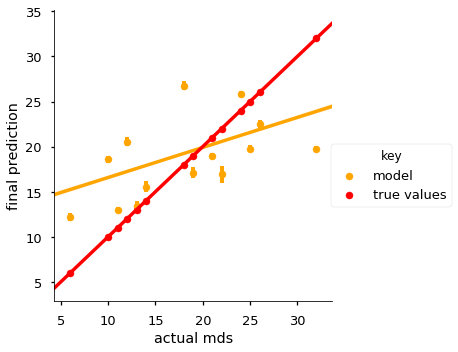

In [7]:
### CALCULATE PREDICTIONS FROM SECOND STACK ###

# build regressors
# clfs = [RandomForestRegressor(n_estimators=50, random_state = 2), MLPRegressor(max_iter = 10000, random_state = 2), 
#        LinearRegression(), Lars(eps = 2.220446049250313e-7), KNeighborsRegressor(weights = 'distance')]
clfs = [MLPRegressor(max_iter = 10000, random_state = 2)]

# display the results for each regressor
for clf_final in clfs:
    
    # setup needed variables
    actual_mds = []; predictions_final = []; subjs3 = []
    
    # use a leave one subject out method to train models
    for s in second_stack_predictions['subj'].unique():

        # split test train data
        second_stack_train = second_stack_predictions[second_stack_predictions.subj != s]
        second_stack_test = second_stack_predictions[second_stack_predictions.subj == s]
        second_stack_ytrain = second_stack_train['actual mds'].values.astype(int)
        second_stack_ytest = second_stack_test['actual mds'].values.astype(int)
        second_stack_train = second_stack_train.iloc[:, 2:].values
        second_stack_test = second_stack_test.iloc[:, 2:].values
        
        # scale data
        scaler = StandardScaler() 
        scaler.fit(second_stack_train)  
        second_stack_std = scaler.transform(second_stack_train)
        second_stack_test_std = scaler.transform(second_stack_test)
        
        # train regressor
        clf_final.fit(second_stack_train, second_stack_ytrain)
        
        # make predictions and store in predictions dataframe
        if (len(second_stack_test) != 0):
            actual_mds += list(second_stack_ytest)
            predictions_final += list(clf_final.predict(second_stack_test))
            subjs3 += [s for elem in list(second_stack_ytest)]
    predictions = pd.DataFrame()
    predictions.insert(loc = len(predictions.columns.values), column = 'subj', value = np.array(subjs3))
    predictions.insert(loc = len(predictions.columns.values), column = 'actual mds', value = np.array(actual_mds))
    predictions.insert(loc = len(predictions.columns.values), column = 'final prediction', value = np.array(predictions_final))
    display(predictions.corr())
    
    # display results
    predictions['key'] = 'model'
    actual_for_comp = pd.DataFrame()
    actual_for_comp['subj'] = predictions['subj']
    actual_for_comp['actual mds'] = predictions['actual mds']
    actual_for_comp['final prediction'] = predictions['actual mds']
    actual_for_comp['key'] = 'true values'

    print("num data points: " + len(predictions.index.values).__str__())
    print('correlation coefficient: ' + np.corrcoef(predictions['final prediction'], predictions['actual mds'])[0][1].__str__())
    print('RMSE: ' + float(np.sqrt(np.mean((np.array(predictions['final prediction']) - predictions['actual mds'])**2))).__str__()) 
    print('Cohen Kappa Score: ' + cohen_kappa_score([int(p) for p in predictions['final prediction'].values], [int(p) for p in predictions['actual mds']]).__str__()) 
    
    df_display = predictions.append(actual_for_comp, ignore_index = True)
    colors = {'model': 'orange', 'true values': 'r'}
    sns.lmplot(x = 'actual mds', y = 'final prediction', hue = 'key', data = df_display, order = 1, x_estimator= np.mean, palette = colors)
    plt.show()